<a href="https://colab.research.google.com/github/skarot/DeepLearning/blob/main/WordEmbeddingsAndLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake news classifier using LSTM

## Import Libraries

In [127]:

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

## Load data

In [9]:
pwd

'/content'

In [14]:
df = pd.read_csv('train.csv', error_bad_lines = False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


## EDA

In [15]:
df.head(5)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [38]:
df.shape

(20800, 5)

In [32]:
df.isnull().values.any()

True

In [34]:
df['title'].isnull().sum()

558

In [35]:
df['text'].isnull().sum()

39

In [36]:
df['label'].isnull().sum()

0

Since there are lot of rows dropping rows with null title is optimal here.


In [52]:
df_nonNull = df[df['title'].notnull()]

In [53]:
df_nonNull

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


## Split dependent and independent variables

In [56]:
X = df_nonNull.drop('label',axis = 1)

In [57]:
X

,id,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...
...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [163]:
y = df_nonNull['label']

In [164]:
y

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20242, dtype: int64

## Preprocesing:
* Tokenize
* Stemming
* Lametization


In [64]:
voc_size = 5000

In [142]:
messages = X['title']

In [143]:
type(messages[0])

str

In [144]:
len(messages)

20242

In [145]:
messages[0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [146]:
messages[0].split()

['House',
 'Dem',
 'Aide:',
 'We',
 'Didn’t',
 'Even',
 'See',
 'Comey’s',
 'Letter',
 'Until',
 'Jason',
 'Chaffetz',
 'Tweeted',
 'It']

In [150]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Custom code for generating list of stemmed sentences with stopped words removed in lower case

In [154]:
corpus = []
ps = PorterStemmer()
for message in messages:  
  review = re.sub('[^a-zA-Z]', ' ',message)
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
  review = " ".join(review)
  corpus.append(review)



### Other method is to use tokenize from nltk that generates words in each sentences as token.

In [108]:
type(stopwords.words('english'))

list

In [155]:
corpus[0:2]

['hous dem aid even see comey letter jason chaffetz tweet',
 'flynn hillari clinton big woman campu breitbart']

## One Hot Encode

In [ ]:
onehot_repr = [one_hot(word,voc_size) for word in corpus]
onehot_repr

## Word Embeddings

### Add padding

In [157]:
sent_length=15
embeded_docs = pad_sequences(onehot_repr,maxlen= sent_length, padding = 'pre')

In [158]:
embeded_docs[2]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       2624, 2236, 1637, 2316], dtype=int32)

## Build LSTM model

In [136]:
output_feature_vector = 20
model = keras.Sequential([
    keras.layers.Embedding(voc_size,output_feature_vector,input_length=sent_length),
    keras.layers.Dropout(0.3),
    keras.layers.LSTM(100),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1,activation = 'sigmoid')
])

In [137]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [138]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 20)            100000    
                                                                 
 dropout (Dropout)           (None, 15, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               48400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 148,501
Trainable params: 148,501
Non-trainable params: 0
_________________________________________________________________
None


## Train and Test model

In [166]:
X_final = np.array(embeded_docs)

In [167]:
y = np.array(y)

In [168]:
X_final.shape,y.shape

((20242, 15), (20242,))

In [184]:
X_train=[]
X_test= []
y_train = []
y_test = []

In [185]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X_final,y)

## Model training

In [186]:
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs = 10, batch_size=50)

Epoch 1/10
304/304 [==============================] - 7s 22ms/step - loss: 0.0842 - accuracy: 0.9740 - val_loss: 0.0805 - val_accuracy: 0.9749
Epoch 2/10
304/304 [==============================] - 7s 23ms/step - loss: 0.0528 - accuracy: 0.9842 - val_loss: 0.0902 - val_accuracy: 0.9712
Epoch 3/10
304/304 [==============================] - 7s 22ms/step - loss: 0.0414 - accuracy: 0.9878 - val_loss: 0.1116 - val_accuracy: 0.9672
Epoch 4/10
304/304 [==============================] - 7s 23ms/step - loss: 0.0306 - accuracy: 0.9899 - val_loss: 0.1264 - val_accuracy: 0.9613
Epoch 5/10
304/304 [==============================] - 7s 24ms/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.1419 - val_accuracy: 0.9599
Epoch 6/10
304/304 [==============================] - 8s 27ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 0.1542 - val_accuracy: 0.9575
Epoch 7/10
304/304 [==============================] - 8s 25ms/step - loss: 0.0189 - accuracy: 0.9935 - val_loss: 0.2045 - val_accuracy: 0.9508

## Model performance metrics

In [173]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn  

In [202]:
predicted = model.predict(X_test)

In [209]:
predicted[6]

array([1.4198646e-05], dtype=float32)

In [210]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [211]:
y_pred[0]

array([1], dtype=int32)

In [213]:
cm = confusion_matrix(y_test,y_pred)

In [214]:
cm

array([[2421,  155],
       [  95, 2390]])

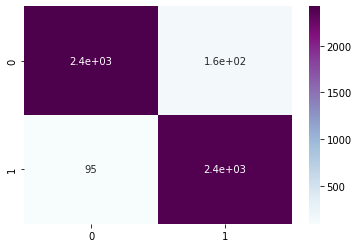

In [224]:
seaborn.heatmap(cm,annot=True, cmap='BuPu')